In [1]:
# importing the necessary packages
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV

# reading in the csv file
data = pd.read_csv('final_data1.csv', index_col=0, header=0)
data.columns

/opt/tljh/user/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the r

Index(['year', 'state', 'months', 'pay_method_ACH', 'pay_method_credit card',
       'pay_method_paper check', 'region_central', 'region_north_east',
       'region_rocky', 'region_south', 'region_south_east', 'region_west',
       'status_Active', 'status_Decline', 'status_Returned',
       'status_Returned_90', 'income', '18_months'],
      dtype='object')

In [2]:
# Dropping rows that will not be used in the random forest
data = data.drop(['state', 'months'], axis = 1)

data.columns

#Renaming columns so they can be passed in the model
data.columns = ['year', 'pay_method_ACH', 'pay_method_credit card',
       'pay_method_paper check', 'region_central', 'region_north_east',
       'region_rocky', 'region_south', 'region_south_east', 'region_west',
       'status_Active', 'status_Decline', 'status_Returned',
       'status_Returned_90', 'income', '18_months']

In [3]:
# Splitting the data in the X and y variables
X = data.iloc[:,:-1]
Y = data['18_months']

# Splitting the data in training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=2019)

In [4]:
# Converting the data set into a matrix
data_matrix = xgb.DMatrix(data=X,label=Y)

/opt/tljh/user/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/tljh/user/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [5]:
# Getting the counts for the majority and minority class 
# in order to set the scale_pos_weight parameter to the
# majority class divided by the minority class
y_train.value_counts()

0    54419
1     8509
Name: 18_months, dtype: int64

In [6]:
# Starting the XGBoost
xg_reg = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100, scale_pos_weight = 6.39546)

# Fitting the xg_reg variable
xg_reg = xg_reg.fit(X_train, y_train)

# Creating the y_pred variable
y_pred = xg_reg.predict(X_test)

# Creating the confusion matrix
cnf_mat = metrics.confusion_matrix(y_test, y_pred)
cnf_mat

array([[12991,  5109],
       [  254,  2623]])

In [7]:
# Creating the rmse model/variable
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE : %f" % (rmse))

RMSE : 0.505629


In [8]:
# Setting the hyper-parameters for k-fold cross validation
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10, 'scale_pos_weight': 6.39546}

# Building the model as we did in week 10 of Data Mining
cv_results = xgb.cv(dtrain=data_matrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=2019)

In [9]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.480001,0.000160,0.480023,0.000147
1,0.475715,0.003457,0.475815,0.003685
2,0.470370,0.006127,0.470485,0.006253
3,0.462566,0.007387,0.462801,0.007196
4,0.453507,0.001478,0.453724,0.001293


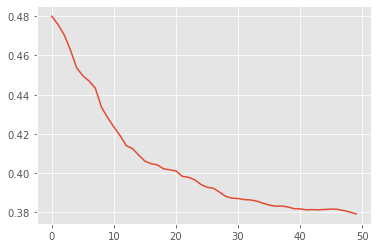

In [10]:
# Plotting the RMSE change over the training of the cross validation model above
plt.style.use('ggplot')

cv_results['test-rmse-mean'].plot()

In [11]:
# Extracting and printing the final boosting round metric.
print((cv_results["train-rmse-mean"]).tail(1))
print((cv_results["test-rmse-mean"]).tail(1))

49    0.378658
Name: train-rmse-mean, dtype: float64
49    0.379159
Name: test-rmse-mean, dtype: float64


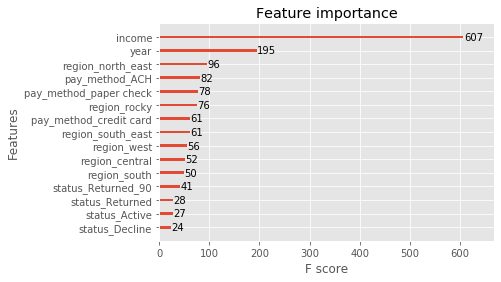

In [12]:
# Using XGBoost's feature importance to come to conclusions about the datasets
# "Building the bridge" for the company
xgb.plot_importance(xg_reg)
plt.show()

In [17]:
# Printing the accuracy, precision, recall, and f1 score 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred, average='weighted'))
print("AUC:", metrics.roc_auc_score(y_test,y_pred))
print("MCC:",metrics.matthews_corrcoef(y_test, y_pred))

Accuracy: 0.7443390379939934
Precision: 0.3392395240558717
Recall: 0.9117135905457073
F1 Score: 0.7830385882515489
AUC: 0.8147241985877707
MCC: 0.44884609008603543
